Logs: [2023/09/05]

- Implementation of ARMA(p, q) 
  `from statsmodesl.tsa.arima_model import ARMA, ARIMA`
  is deprecated. Use SARIMAX

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

**Function declarations**

In [19]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y-%b")
    # locator = mdates.YearLocator(base=2)
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)

When we have a time serie where you cannot infer an order 
from the ACF plot or from the PACF plot because both
figures exhibit a slowly decaying pattern or a
sinusoidal patter, we are in the presence of an autoregressive moving average (ARMA) process.

_Akaike information criterion_ (AIC) will 
determine the optimal combination of $p$ and $q$ 
of our series

We must evaluate the model's validity using residual 
analysis by studying the correlogram, Q-Q plot, 
and the density plot of the model's residuals to assess
if they closely resemble white noise.

## 6.1 Forecasting bandwidth usage for data centers

Suppose that you are tasked with predicting bandwidth
usage for a large data center so that it allows 
data centers to better manage their computing resources.

In [15]:
file_path = "./datasets/bandwidth_with_date.csv"
df_bandwidth = pd.read_csv(file_path, parse_dates=[0])
df_bandwidth

,date,hourly_bandwidth
0,2019-01-01 00:00:00,1000.496714
1,2019-01-01 01:00:00,1000.969408
2,2019-01-01 02:00:00,1002.046019
3,2019-01-01 03:00:00,1004.702118
4,2019-01-01 04:00:00,1007.447816
...,...,...
9995,2020-02-21 11:00:00,740.546059
9996,2020-02-21 12:00:00,738.906228
9997,2020-02-21 13:00:00,736.057995
9998,2020-02-21 14:00:00,733.559640


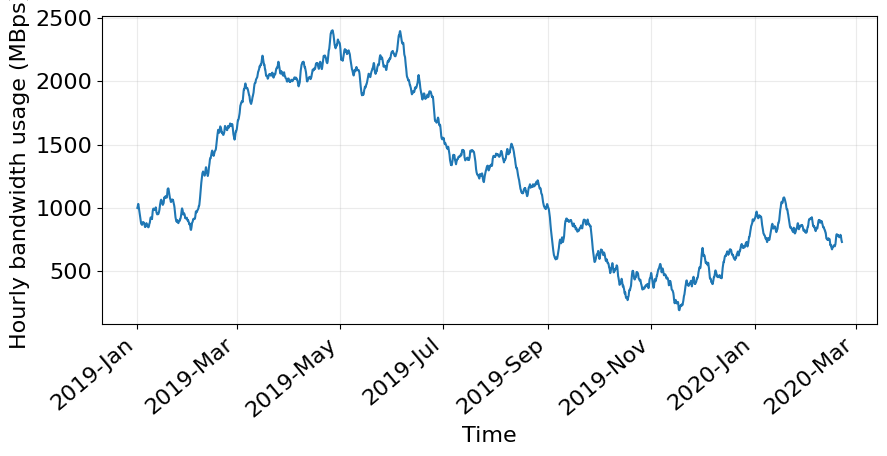

In [20]:
plot_time_series(df_bandwidth["date"], df_bandwidth["hourly_bandwidth"], 
                 ylabel="Hourly bandwidth usage (MBps)")

In order to forecast bandwidth usage, we step-by-step follow the below
procedures:
1. Collect data (it is already done in `bandwidth_with_date.csv`)
2. Determine if our series is stationary or not 
   - Use ADF test (calculate ADF statistic and $p$-value)
   - Apply transformation, recompute ADF statistic and $p$-value
3. Plot ACF to determine random walk or not
   - If the coefficients become abruptly non-significant
     after lag $q$, we have moving average process and stop.   
     If it is not the case, continue 
4. Plot PACF to determine autoregressive process or not
   - If the coefficients become abruptly non-significant
     after lag $p$, we have autoregressive process and stop.
     If it is not the case, we have combination of 
     moving average and autoregressive process.


## 6.2 Examining the autoregressive moving average process

**Autoregressive moving average process**    
The autoregressive moving average process is a combination
of the autoregressive process and the moving average process.

It is denoted as $\text{ARMA}(p,q)$, where $p$ is the order of 
the autoregressive process, and $q$ is the order of the moving 
average process. The general equaton of the $\text{ARMA}(p,q)$
model is
$$
  y_t = C  + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p}
        + \mu + \epsilon_t + \theta_1 \epsilon_{t-1}
          + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q}
$$

An $\text{ARMA}(0, q)$ process is equivalent to an $\text{MA}(q)$
process, since the order $p=0$ cancels the $\text{AR}(p)$ portion.
An $\text{ARMA}(p, 0)$ process is equivalent to an 
$\text{AR}(p)$ process, since the order $q = 0$ cancels 
the $\text{MA}(q)$ portion.

### 6.3 Identifying a stationary ARMA process

An extension step-by-step to determine the model of $\text{ARMA}(p,q)$

<img src="./figures/identify-stationary-order-arma.drawio.png" width=1000>

Let us simuate ARMA process before we apply ARMA model to forecast
bandwidth usage

Our $\text{ARMA}(1, 1)$ model is governed by the following equation:
$$
  y_t = 0.33 y_{t-1} + 0.9 \epsilon_{t-1} + \epsilon_t
$$

Then using that equation, we generate $1,000$ samples

In [23]:
seed = 20230912
rng = np.random.default_rng(seed)
distrvs = lambda size: rng.standard_normal(size)

ma1_coeff = np.array([1, 0.9])
ar1_coeff = np.array([1, -0.33])

arma_1_1_process = ArmaProcess(ar1_coeff, ma1_coeff)\
    .generate_sample(nsample=1000, distrvs=distrvs)

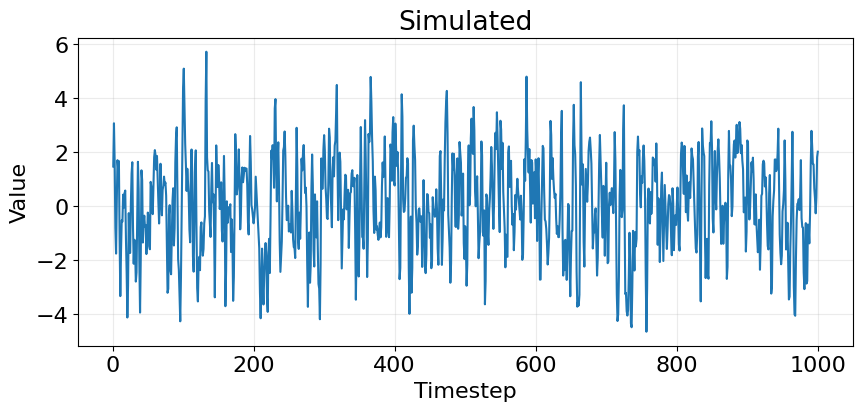

In [24]:
plot_time_series(np.arange(1, 1001), arma_1_1_process, 
                 ylabel="Value", xlabel="Timestep", use_date_locator=False,
                 title="Simulated")

With our simulated data ready, we can move on the next
step and verify whether our process is stationary or not.

In [25]:
ADF_result = adfuller(arma_1_1_process)
print(f"ADF statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF statistic: -7.298704116754308
p-value: 1.3563970905368267e-10


Since we have a large negative ADF statistic and $p$-value that's
much smaller than $0.05$, we can conclude that our simulated 
$\text{ARMA}(1,1)$ process is stationary

The next step by plotting ACF plot whether we can infer the 
order of moving average proceess or not

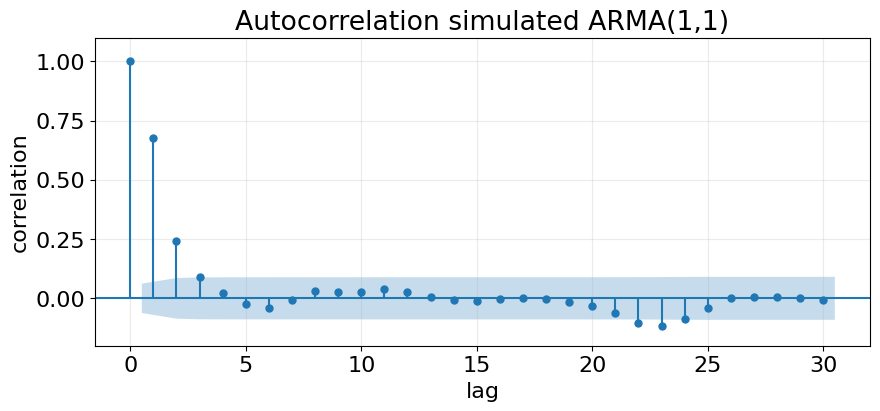

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(arma_1_1_process, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation simulated ARMA(1,1)")
ax.grid("on")

plt.show(fig)

We notice from the above plot that last significant
coefficient is at lag 2. However, we know that our
simulted data has an $\text{MA}(1)$ process, so we would expect
to have significant coefficients up to lag 1 only. 

We can thus conclude that the ACF plot does not reveal any
useful information about the order $q$ of our $\text{ARMA}(1,1)$
process.

Now we move on the next step and use plot PACF

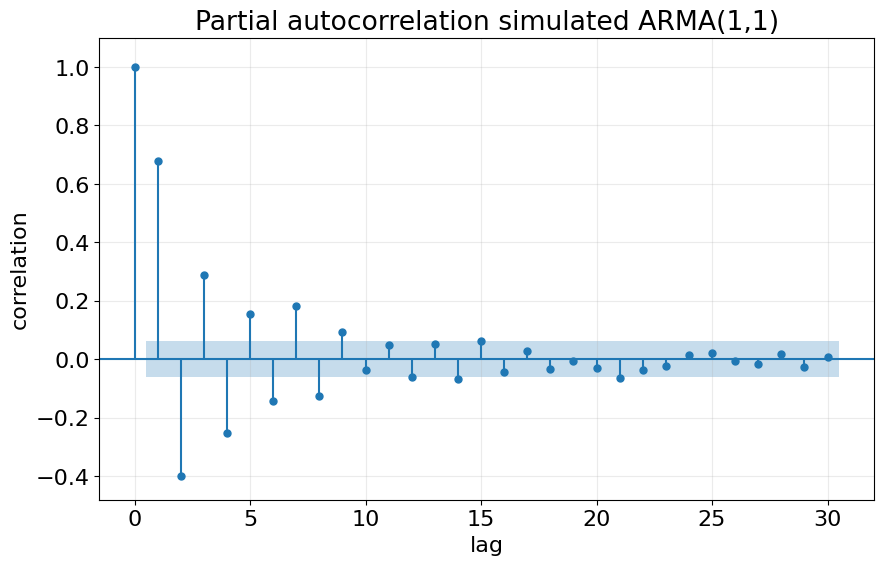

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

fig = plot_pacf(arma_1_1_process, lags=30, ax=ax)

ax.set_ylim([-.48, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Partial autocorrelation simulated ARMA(1,1)")
ax.grid("on")

plt.show(fig)


We can clearly see from the plot that te correlations past lag 1.
Another feature is we do not have abruptly changes in correlations
and we easily notice a sinusoidal pattern.

We know that we simulated an $\text{ARMA}(1, 1)$ so the PACF plot
cannot be used to find the order $p$ of an $\text{ARMA}(p,q)$
process.

**Identifying a statonary $\text{ARMA}(p,q)$ process**    
If your process is stationary and both the ACF and PACF plots
show a decayig or sinusoidal pattern, then it is a stationar
$\text{ARMA}(p,q)$ process.

## 6.4 Devising a general modeling procedure

Our general strategy to determine the order of ARMA process
should not depend on qualitative plot of ACF and PACF.
The following strategy is based entirely on statistical tests
and numerical criteria

<img src="./figures/identify-stationary-general-procedure-arma.drawio.png" width=400>

## Fix some bugs in data

Add date to `bandwidth.csv`. Frequency of the time is hourly.

In [14]:
file_path = "./datasets/bandwidth.csv" 
df_bandwidth_with_date = pd.read_csv(file_path)

df_bandwidth_with_date["date"] \
  = pd.date_range(start="2019-01-01", periods=len(df_bandwidth_with_date), freq="H")
df_bandwidth_with_date = df_bandwidth_with_date[["date", "hourly_bandwidth"]]

df_bandwidth_with_date.to_csv("./datasets/bandwidth_with_date.csv", index=False)

df_bandwidth_with_date

,date,hourly_bandwidth
0,2019-01-01 00:00:00,1000.496714
1,2019-01-01 01:00:00,1000.969408
2,2019-01-01 02:00:00,1002.046019
3,2019-01-01 03:00:00,1004.702118
4,2019-01-01 04:00:00,1007.447816
...,...,...
9995,2020-02-21 11:00:00,740.546059
9996,2020-02-21 12:00:00,738.906228
9997,2020-02-21 13:00:00,736.057995
9998,2020-02-21 14:00:00,733.559640
